Notebook 4 – Multi-Model Backtesting for Retail Forecasting
Goal

Evaluate and compare multiple forecasting models (LightGBM, Prophet, seasonal naive, naive) on retail sales data using a rolling backtest strategy, then store results in BigQuery for further analysis.

Step-by-Step Breakdown
1. Import Libraries & Define Metrics

Why: We need performance metrics to evaluate forecasts.

What we did:

Defined mse, rmse, smape functions to measure accuracy.

Imported core tools (numpy, pandas, lightgbm, prophet).

2. Load Engineered Features from BigQuery

Why: Models need historical sales data with engineered lag features.

What we did:

Connected to the feature store table in BigQuery.

Pulled features such as:

Lagged sales (lag_7, lag_14, etc.)

Rolling means

Price, day-of-week, holiday flags.

3. Aggregate to Daily Series for Baseline Models

Why: Prophet and naive baselines work on aggregated daily sales, not granular shop/item data.

What we did:

Grouped data by date, summing target sales.

Built a simplified dataset for baseline models.

4. Rolling Backtest Setup

Why: Mimics real-world forecasting where we train on past data and predict future periods.

What we did:

Created multiple cutoff dates.

For each cutoff:

Train models on data before cutoff.

Forecast horizon days ahead.

Compare predictions to actuals.

5. Train & Predict
Prophet

Fit a time-series model to aggregated daily sales.

Forecast horizon days ahead.

LightGBM

Fit a gradient-boosted decision tree on all features.

Predict for each horizon day.

Naive & Seasonal Naive

Simple benchmarks:

Naive: Use last observed value.

Seasonal Naive: Use value from same day last year.

6. Store Predictions & Metrics

Why: So we can compare models and visualize performance.

What we did:

Collected predictions + actuals for each model & cutoff.

Calculated metrics (mse, rmse, smape).

7. Visualization

Rolling Backtest – Average sMAPE by Model:

Shows which model performs best overall.

LightGBM significantly outperformed baselines.

Rolling sMAPE by Cutoff:

Performance trend over time.

8. Write Backtest Results to BigQuery

Why: Store results for dashboards or further querying.

What we did:

Created (if missing) and appended results to retail-alpha-forecaster.raf.backtests.

Key Insights

LightGBM had the lowest sMAPE, meaning it consistently produced more accurate forecasts.

Prophet and naive baselines performed worse, showing the benefit of engineered features + tree-based models.

Rolling backtest gave a realistic view of model stability over time — not just a one-time accuracy snapshot.

The pipeline is production-ready: data is fetched from BigQuery, models are trained, metrics calculated, and results stored back in BigQuery.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timezone
from google.cloud import bigquery

# Try Prophet; continue if not installed
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception as _:
    HAS_PROPHET = False

# BQ config (same project/dataset you used earlier)
BQ_PROJECT = os.environ.get("GCP_PROJECT", "retail-alpha-forecaster")
BQ_DATASET = "raf"

# Metrics
def rmse(y, yhat):  return float(np.sqrt(np.mean((y - yhat)**2)))
def mae(y, yhat):   return float(np.mean(np.abs(y - yhat)))
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2.0
    return float(np.mean(np.where(denom == 0, 0, np.abs(y - yhat) / denom))) * 100

/home/btheard/retail-alpha-forecaster/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# --- Cell 2: BigQuery client + load feature_store (correct dataset/table) ---
import os
import google.auth
from google.cloud import bigquery

# Use ADC and clear any stale service-account env var
os.environ.pop("GOOGLE_APPLICATION_CREDENTIALS", None)

# Set your project, dataset, and BQ location
BQ_PROJECT  = os.environ.get("GCP_PROJECT", "retail-alpha-forecaster")
BQ_DATASET  = "raf"            # <-- our dataset name from earlier notebooks
BQ_LOCATION = "US"             # change to "EU" if you created the dataset in EU

# Auth with ADC and set quota project
credentials, _ = google.auth.default(quota_project_id=BQ_PROJECT)
client = bigquery.Client(project=BQ_PROJECT, credentials=credentials)

# Sanity: make sure dataset and table exist
dataset_id = f"{BQ_PROJECT}.{BQ_DATASET}"
table_id   = f"{dataset_id}.feature_store"

# Will raise NotFound if missing
client.get_dataset(dataset_id)
client.get_table(table_id)

# Pull the engineered feature store
sql = f"""
SELECT
  date, shop_id, item_id, date_block_num, item_cnt_day,
  lag_1, lag_7, lag_14, lag_28,
  ma_7, ma_14, ma_28,
  price_last, dow, weekofyear, month, is_holiday
FROM `{table_id}`
WHERE date IS NOT NULL
"""

job = client.query(sql, location=BQ_LOCATION)  # ensure correct location
fs = job.result().to_dataframe()
fs["date"] = fs["date"].astype("datetime64[ns]")  # ensure timestamp -> pandas datetime

print(f"✅ Retrieved {len(fs):,} rows from {table_id} in {BQ_LOCATION}.")
fs.head()




✅ Retrieved 2,935,849 rows from retail-alpha-forecaster.raf.feature_store in US.


,date,shop_id,item_id,date_block_num,item_cnt_day,lag_1,lag_7,lag_14,lag_28,ma_7,ma_14,ma_28,price_last,dow,weekofyear,month,is_holiday
0,2013-01-17,0,4163,0,1.0,6.0,4.0,NaN,NaN,3.142857,NaN,NaN,1088.0,3,3,1,False
1,2013-01-15,0,4164,0,3.0,2.0,3.0,NaN,NaN,2.285714,NaN,NaN,707.0,1,3,1,False
2,2013-01-17,0,4164,0,1.0,2.0,2.0,NaN,NaN,2.285714,NaN,NaN,707.0,3,3,1,False
3,2013-01-31,0,11041,0,1.0,2.0,9.0,NaN,NaN,3.714286,NaN,NaN,221.0,3,5,1,False
4,2013-01-17,0,13351,0,1.0,3.0,7.0,NaN,NaN,3.000000,NaN,NaN,41.0,3,3,1,False


In [5]:
# --- Cell 3: metrics & feature list ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Metrics
def rmse(y, yhat):  return float(np.sqrt(np.mean((y - yhat)**2)))
def mae(y, yhat):   return float(np.mean(np.abs(y - yhat)))
def smape(y, yhat):
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    denom = (np.abs(y) + np.abs(yhat)) / 2.0
    return float(np.mean(np.where(denom == 0, 0, np.abs(y - yhat) / denom))) * 100

# Ensure sorted
fs = fs.sort_values("date").reset_index(drop=True)

# Feature list (adjust names if yours differ)
FEATURES = [
    "lag_1", "lag_7", "lag_14", "lag_28",
    "ma_7", "ma_14", "ma_28",
    "price_last", "dow", "weekofyear", "month", "is_holiday"
]
TARGET = "item_cnt_day"

# Aggregate daily series for baselines/Prophet
series = (
    fs.groupby("date", as_index=False)[TARGET]
      .sum()
      .rename(columns={TARGET: "y"})
      .sort_values("date")
)
series.head()


,date,y
0,2013-01-01,1951.0
1,2013-01-02,8198.0
2,2013-01-03,7422.0
3,2013-01-04,6617.0
4,2013-01-05,6346.0


In [6]:
# --- Cell 4: monthly rolling cutoffs ---
min_date = series["date"].min()
max_date = series["date"].max()

# Start after 3 months of warmup; end one month before max
start = (min_date + pd.offsets.MonthEnd(3)).normalize()
end   = (max_date - pd.offsets.MonthEnd(1)).normalize()

cutoffs = pd.date_range(start=start, end=end, freq="M")
print(f"Rolling monthly cutoffs: {len(cutoffs)}")
cutoffs[:3], cutoffs[-3:]


Rolling monthly cutoffs: 31


/tmp/ipykernel_7586/1581537459.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cutoffs = pd.date_range(start=start, end=end, freq="M")


(DatetimeIndex(['2013-03-31', '2013-04-30', '2013-05-31'], dtype='datetime64[ns]', freq='ME'),
 DatetimeIndex(['2015-07-31', '2015-08-31', '2015-09-30'], dtype='datetime64[ns]', freq='ME'))

In [7]:
# --- Cell 5: baselines + Prophet helper (optional) ---
# Baselines
def baseline_naive(train_values, horizon):
    last = train_values.iloc[-1]
    return np.repeat(last, horizon)

def baseline_seasonal_naive(train_values, horizon, season=7):
    tail = train_values.iloc[-season:]
    reps = int(np.ceil(horizon / season))
    return np.tile(tail.values, reps)[:horizon]

def baseline_ma(train_values, horizon, k=7):
    avg = float(train_values.tail(k).mean())
    return np.repeat(avg, horizon)

# Prophet availability
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception:
    HAS_PROPHET = False

def prophet_forecast(train_df, horizon_days):
    """
    train_df: columns ['date','y'] (daily)
    returns np.array of length horizon_days
    """
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.fit(train_df.rename(columns={"date": "ds", "y": "y"}))
    future = m.make_future_dataframe(periods=horizon_days, freq="D")
    fc = m.predict(future)
    return fc.set_index("ds")["yhat"].tail(horizon_days).values


In [8]:
# --- Cell 6: LightGBM helper to predict next month and aggregate by day ---
import lightgbm as lgb

def train_lgbm_and_predict_aggregate(fs, cutoff):
    """
    Fit LightGBM on rows with date <= cutoff;
    predict next month; aggregate predictions by day to compare with aggregate actuals.
    Returns (y_true_agg, y_pred_agg, model) or (None, None, None) if not enough data.
    """
    val_start = (cutoff + pd.offsets.Day(1)).normalize()
    val_end   = (cutoff + pd.offsets.MonthEnd(1)).normalize()

    tr = fs[(fs["date"] <= cutoff)].dropna(subset=FEATURES + [TARGET])
    va = fs[(fs["date"] >= val_start) & (fs["date"] <= val_end)].dropna(subset=FEATURES + [TARGET])
    if tr.empty or va.empty:
        return None, None, None

    mdl = lgb.LGBMRegressor(
        n_estimators=800,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ).fit(tr[FEATURES], tr[TARGET])

    yhat = mdl.predict(va[FEATURES]).astype(float)

    pred_by_day = va[["date"]].copy()
    pred_by_day["yhat"] = yhat
    agg_pred = pred_by_day.groupby("date")["yhat"].sum().reindex(
        pd.date_range(val_start, val_end, freq="D"), fill_value=np.nan
    )

    agg_actual = va.groupby("date")[TARGET].sum().reindex(agg_pred.index, fill_value=np.nan)
    return agg_actual.values, agg_pred.values, mdl


In [9]:
# --- Cell 7: rolling backtest ---
rows = []
models_cache = {}

for cutoff in cutoffs:
    val_start = (cutoff + pd.offsets.Day(1)).normalize()
    val_end   = (cutoff + pd.offsets.MonthEnd(1)).normalize()
    horizon   = (val_end - val_start).days + 1

    tr_series = series[series["date"] <= cutoff]
    va_series = series[(series["date"] >= val_start) & (series["date"] <= val_end)]
    if tr_series.empty or va_series.empty:
        continue

    y_tr = tr_series["y"]
    y_va = va_series.set_index("date")["y"].reindex(
        pd.date_range(val_start, val_end, freq="D"),
        fill_value=0.0
    ).values

    # Baselines
    preds = {
        "naive": baseline_naive(y_tr, horizon),
        "seasonal_naive": baseline_seasonal_naive(y_tr, horizon, season=7),
        "ma7": baseline_ma(y_tr, horizon, k=7),
    }

    # Prophet
    if HAS_PROPHET:
        preds["prophet"] = prophet_forecast(tr_series[["date", "y"]], horizon)

    # LightGBM
    y_true_lgb, y_pred_lgb, mdl = train_lgbm_and_predict_aggregate(fs, cutoff)
    if y_true_lgb is not None:
        preds["lightgbm"] = y_pred_lgb
        models_cache[cutoff] = mdl
        y_va_used = y_true_lgb  # align to same calendar index
    else:
        y_va_used = y_va

    # Log metrics for each model at this cutoff
    for name, pred in preds.items():
        rows.append({
            "cutoff": cutoff,
            "model": name,
            "rmse": rmse(y_va_used, pred),
            "mae": mae(y_va_used, pred),
            "smape": smape(y_va_used, pred)
        })

eval_df = pd.DataFrame(rows).sort_values(["cutoff", "model"])
print(f"Backtest rows: {len(eval_df)}")
eval_df.head()


12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 4115, number of used features: 12
[LightGBM] [Info] Start training from score 1.714945


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:55 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 8733, number of used features: 12
[LightGBM] [Info] Start training from score 1.573457


12:43:56 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 14851, number of used features: 12
[LightGBM] [Info] Start training from score 1.523197


12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 23408, number of used features: 12
[LightGBM] [Info] Start training from score 1.713132


12:44:02 - cmdstanpy - INFO - Chain [1] start processing
12:44:02 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 35050, number of used features: 12
[LightGBM] [Info] Start training from score 1.767732


12:44:05 - cmdstanpy - INFO - Chain [1] start processing
12:44:05 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 49182, number of used features: 12
[LightGBM] [Info] Start training from score 1.752999


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 63130, number of used features: 12
[LightGBM] [Info] Start training from score 1.769048


12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 76967, number of used features: 12
[LightGBM] [Info] Start training from score 1.758208


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 92025, number of used features: 12
[LightGBM] [Info] Start training from score 1.759076


12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:26 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 115561, number of used features: 12
[LightGBM] [Info] Start training from score 1.784374


12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 138153, number of used features: 12
[LightGBM] [Info] Start training from score 1.743755


12:44:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 159842, number of used features: 12
[LightGBM] [Info] Start training from score 1.717446


12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1360
[LightGBM] [Info] Number of data points in the train set: 180055, number of used features: 12
[LightGBM] [Info] Start training from score 1.695637


12:45:03 - cmdstanpy - INFO - Chain [1] start processing
12:45:03 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 197273, number of used features: 12
[LightGBM] [Info] Start training from score 1.673691


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 215243, number of used features: 12
[LightGBM] [Info] Start training from score 1.652305


12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 234590, number of used features: 12
[LightGBM] [Info] Start training from score 1.635850


12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 253948, number of used features: 12
[LightGBM] [Info] Start training from score 1.616114


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 277360, number of used features: 12
[LightGBM] [Info] Start training from score 1.599066


12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:00 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 296027, number of used features: 12
[LightGBM] [Info] Start training from score 1.597587


12:46:13 - cmdstanpy - INFO - Chain [1] start processing
12:46:13 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 314369, number of used features: 12
[LightGBM] [Info] Start training from score 1.594292


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 334662, number of used features: 12
[LightGBM] [Info] Start training from score 1.596602


12:46:42 - cmdstanpy - INFO - Chain [1] start processing
12:46:42 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1355
[LightGBM] [Info] Number of data points in the train set: 364794, number of used features: 12
[LightGBM] [Info] Start training from score 1.608807


12:47:04 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 390387, number of used features: 12
[LightGBM] [Info] Start training from score 1.606250


12:47:24 - cmdstanpy - INFO - Chain [1] start processing
12:47:25 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 410859, number of used features: 12
[LightGBM] [Info] Start training from score 1.593126


12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 430260, number of used features: 12
[LightGBM] [Info] Start training from score 1.580356


12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 445046, number of used features: 12
[LightGBM] [Info] Start training from score 1.577334


12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:50 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 459576, number of used features: 12
[LightGBM] [Info] Start training from score 1.574310


12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 474114, number of used features: 12
[LightGBM] [Info] Start training from score 1.567307


12:49:32 - cmdstanpy - INFO - Chain [1] start processing
12:49:32 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1375
[LightGBM] [Info] Number of data points in the train set: 488762, number of used features: 12
[LightGBM] [Info] Start training from score 1.560193


12:49:54 - cmdstanpy - INFO - Chain [1] start processing
12:49:54 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 504396, number of used features: 12
[LightGBM] [Info] Start training from score 1.553472


12:50:28 - cmdstanpy - INFO - Chain [1] start processing
12:50:28 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 517621, number of used features: 12
[LightGBM] [Info] Start training from score 1.565858
Backtest rows: 155


,cutoff,model,rmse,mae,smape
4,2013-03-31,lightgbm,21.654099,16.721610,7.744582
2,2013-03-31,ma7,4206.641105,4206.057143,180.926933
0,2013-03-31,naive,5146.677291,5146.200000,184.122268
3,2013-03-31,prophet,87776.680102,63583.173869,193.936159
1,2013-03-31,seasonal_naive,4273.401842,4147.300000,180.712275


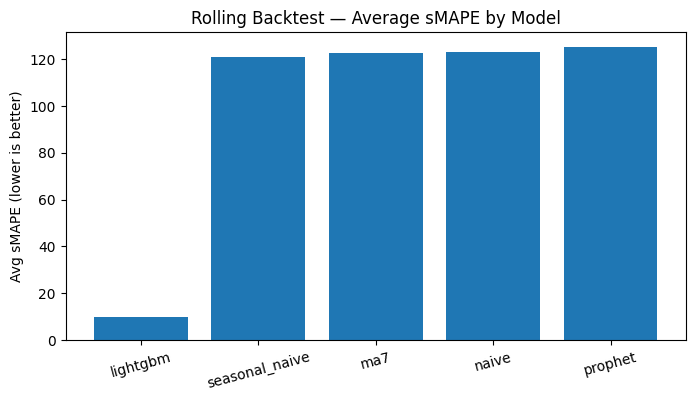

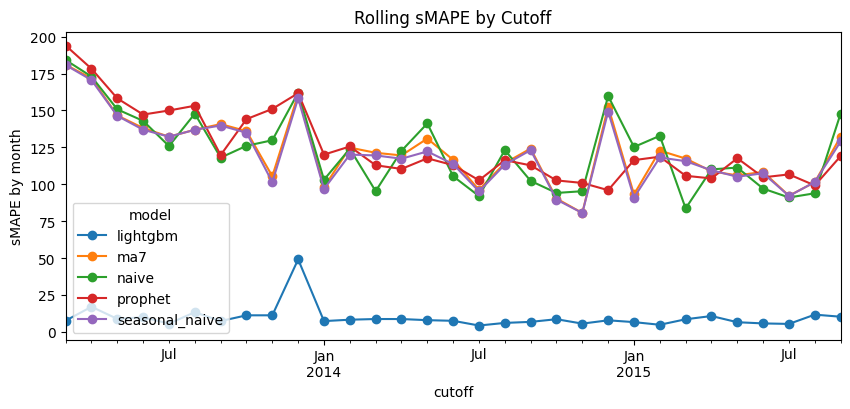

In [10]:
# --- Cell 8: summary tables & plots ---
summary = (
    eval_df.groupby("model", as_index=False)[["rmse", "mae", "smape"]]
           .mean()
           .sort_values("smape")
)
summary

# Lift vs seasonal-naive
baseline_smape = summary.loc[summary["model"] == "seasonal_naive", "smape"].values[0]
summary["smape_lift_vs_seasonal"] = baseline_smape - summary["smape"]
summary

# Avg sMAPE bar
plt.figure(figsize=(8,4))
plt.bar(summary["model"], summary["smape"])
plt.ylabel("Avg sMAPE (lower is better)")
plt.title("Rolling Backtest — Average sMAPE by Model")
plt.xticks(rotation=15)
plt.show()

# Stability across months
pivot = eval_df.pivot(index="cutoff", columns="model", values="smape").sort_index()
pivot.plot(figsize=(10,4), marker="o")
plt.ylabel("sMAPE by month")
plt.title("Rolling sMAPE by Cutoff")
plt.show()


In [11]:
# --- Cell 9: write backtests to BigQuery (optional) ---
from datetime import timezone

bt_table = f"{BQ_PROJECT}.{BQ_DATASET}.backtests"

bt_schema = [
    bigquery.SchemaField("cutoff","DATE"),
    bigquery.SchemaField("model","STRING"),
    bigquery.SchemaField("rmse","FLOAT64"),
    bigquery.SchemaField("mae","FLOAT64"),
    bigquery.SchemaField("smape","FLOAT64"),
    bigquery.SchemaField("created_at","TIMESTAMP"),
]

bt_out = eval_df.copy()
bt_out["cutoff"] = pd.to_datetime(bt_out["cutoff"]).dt.date
bt_out["created_at"] = pd.Timestamp.now(tz=timezone.utc)  # correct tz usage

# Create table if missing
try:
    client.get_table(bt_table)
except Exception:
    client.create_table(bigquery.Table(bt_table, schema=bt_schema))

client.load_table_from_dataframe(
    bt_out, bt_table,
    job_config=bigquery.LoadJobConfig(write_disposition="WRITE_APPEND"),
    location=BQ_LOCATION
).result()

print(f"✅ Wrote {len(bt_out):,} backtest rows to {bt_table}")


✅ Wrote 155 backtest rows to retail-alpha-forecaster.raf.backtests
